Defaulting to user installation because normal site-packages is not writeable
1875


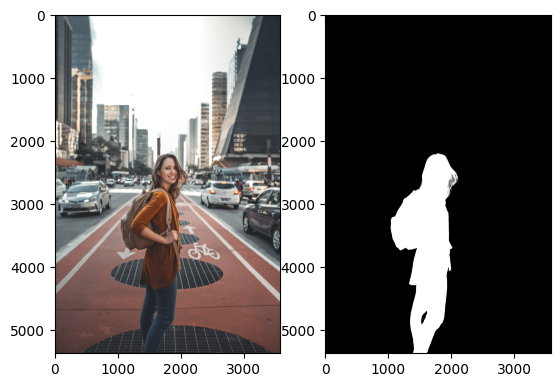

In [1]:
! pip install matplotlib
# check for the fgr_pha.py ForegroundAlphaDataset
from dataset.fgr_phas import ForegroundAlphaDataset
dataset = ForegroundAlphaDataset(((0,1),2))
print(len(dataset))
# visualize the first item
data = dataset[0]
image = data['image']
alpha = data['alpha']
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(alpha, cmap='gray')
plt.show()

<KeysViewHDF5 ['image']>
46839
(448, 448, 3)
0 255


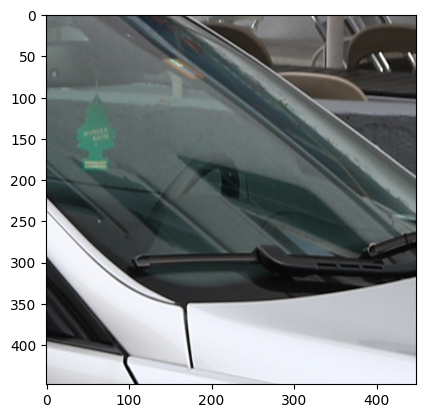

In [2]:
# load the zurich RAW–RGB dataset (Replacing Mobile Camera ISP with a Single Deep Learning Model)
import json,h5py,os
import matplotlib.pyplot as plt 
config_path='dataset/datasets_config.json'
with open(config_path, 'r') as file:
    config = json.load(file)
img_paths = os.path.join(config["data_path"], config['zurich_raw']['train'])
with h5py.File(img_paths, 'r') as file:
    print(file.keys())
    image = file['image'][0]
    print(len(file['image']))
    plt.imshow(image)
    print(image.shape)
    print(image.min(), image.max())

alpha torch.Size([1, 1080, 1920])
fgr_gamma torch.Size([3, 1080, 1920])
bgr_gamma torch.Size([3, 1080, 1920])
fgr_linear torch.Size([3, 1080, 1920])
bgr_linear torch.Size([3, 1080, 1920])
comp_gamma torch.Size([3, 1080, 1920])
comp_linear torch.Size([3, 1080, 1920])
fgrs_linear torch.Size([8, 3, 1080, 1920])
bgrs_linear torch.Size([8, 3, 1080, 1920])
fgrs_gamma torch.Size([8, 3, 1080, 1920])
bgrs_gamma torch.Size([8, 3, 1080, 1920])
alpha_burst torch.Size([8, 1, 1080, 1920])
comp_burst torch.Size([8, 3, 1080, 1920])
comp_burst_gamma torch.Size([8, 3, 1080, 1920])
torch.Size([8, 3, 1080, 1920]) torch.Size([8, 3, 3])


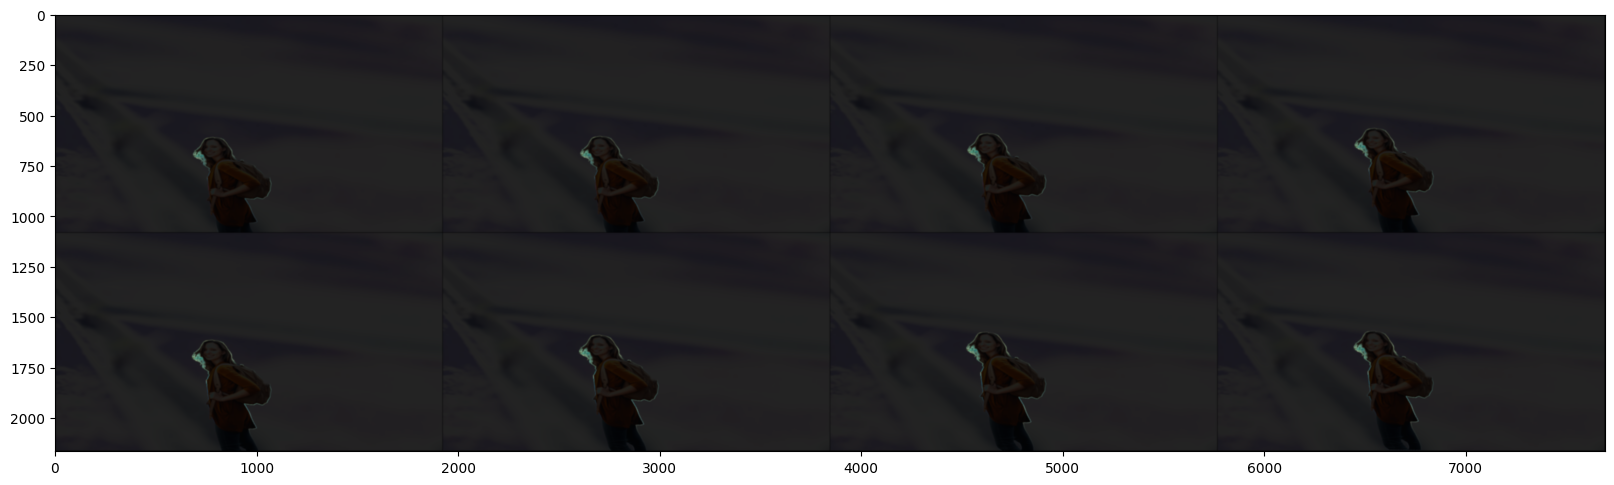

In [3]:
# test the initial version of the synthetic burst dataset
from dataset.synthetic_burst import SyntheticBurstDataset
import gin
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
import torch
def visualize_shifts(shift_tensor):
    shifts = shift_tensor.numpy()
    sample_index = 1

    x_shifts = shifts[sample_index, 0, :, :]
    y_shifts = shifts[sample_index, 1, :, :]
    print(x_shifts)
    Y, X = np.mgrid[0:512, 0:512]
    step = 16  
    plt.figure(figsize=(10, 10))
    plt.quiver(X[::step, ::step], Y[::step, ::step], x_shifts[::step, ::step], y_shifts[::step, ::step], 
            angles='xy', scale_units='xy', scale=1)
    plt.gca().invert_yaxis()  

    plt.title(f'Vector field of displacements for sample {sample_index}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

gin.parse_config_file('configs/matting/image2burst.gin')
dataset = SyntheticBurstDataset()
import matplotlib.pyplot as plt
from utils.image.rgb2raw import process_linear_image_raw
data = dataset[0]
plt.figure(figsize=(20, 16))
# visualize_shifts(data['metadata']['shifts'])
for key in data.keys():
    if not key.endswith('metadata'):
        print(key, data[key].shape)
        # if key == "fgr_gamma":
        #     plt.imshow(transforms.ToPILImage()(data[key]), interpolation="bicubic")
        # if key == "fgrs_gamma":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "comp_burst":
        #     output = process_linear_rgb_batch(data[key])
        #     grid = make_grid(output, nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "comp_burst":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "phas":
        #     plt.imshow(transforms.ToPILImage()(data[key]), cmap='gray')
        # if key == "comp_burst":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
# visualize the 'fgr_gamma', 'bgr_gamma', 'fgr_linear', 'bgr_linear', 'comp_gamma', 'comp_linear' in one figure
# visual_data = [data[key] for key in ['fgr_gamma', 'bgr_gamma', 'fgr_linear', 'bgr_linear', 'comp_gamma', 'comp_linear']]
# grid = make_grid(visual_data, nrow=2, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
data["unprocess_metadata"]["cam2rgb"] = data["unprocess_metadata"]["cam2rgb"][:8]
print(data["comp_burst"].shape, data["unprocess_metadata"]["cam2rgb"].shape)
comp_burst = process_linear_image_raw(data["comp_burst"], data["unprocess_metadata"],demosaic=False)
diff = torch.abs(comp_burst - data["comp_burst_gamma"])
print(diff.min(), diff.max())
diff -= diff.min() 
diff /= diff.max()
diff_grid = make_grid(diff, nrow=4, padding=2, normalize=True)
plt.imshow(transforms.ToPILImage()(diff_grid), interpolation="bicubic")
# for_visual = torch.cat([comp_burst, data["comp_burst_gamma"],diff], dim=0)
# grid = make_grid(for_visual, nrow=4, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")